In [1]:
from music21 import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import random
import decimal

from helpers import *

Using TensorFlow backend.


In [2]:
# get bach paths
paths = corpus.getComposer('bach')
#paths = corpus.getComposer('mozart')

# get n pieces
#paths = paths[:10]

# get all the notes of the first part of each piece
notes = []
midi_notes = []

# use only 2 songs
paths = paths[:2]
for path in paths:
    # repeat the n songs m times to generate the training data
    for _ in range(30):
        compStream = converter.parse(path)
        notes.extend(list(compStream.parts[0].recurse().notes))

# convert to midi notes
midi_notes = []
for n in notes:
    # handle chords -> get hightest pitch
    if isinstance(n, chord.Chord):
        midi_notes.append(n.pitches[-1].midi)
    else:
        midi_notes.append(n.pitch.midi)

print(f'len(notes): {len(notes)}')
print(f'len(midi_notes): {len(midi_notes)}')
print(midi_notes[:50])

# save a copy  of the original midi notes
midi_notes_org = midi_notes[:]

# write source melody to file
s, fp = to_midi_file(midi_notes_org[:500], 'source.midi')

len(notes): 5970
len(midi_notes): 5970
[65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 65, 67]


In [3]:
# turn notes in to training sequences of n e.g. 4
# map each sequence to note that follows
# [65, 67, 60, 65] -> 53
# [67, 60, 65, 53] -> 57

# set the length of the sequence that predicts the next note
seq_length = 4

# scale data
midi_notes = np.array(midi_notes_org).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
midi_notes = scaler.fit_transform(midi_notes)
# print(f'scaled midi_notes:\n{midi_notes}')

data = []
labels = []
for i in range(len(midi_notes)):
    seq_end = i + seq_length
    
    if seq_end >= len(midi_notes): break
    
    seq = midi_notes[i:seq_end]        
    data.append(seq)
    labels.append(midi_notes[seq_end])

print(f'data:\n{data[0]}')
print(f'labels:\n{labels[0]}')

data:
[[0.5       ]
 [0.58333333]
 [0.29166667]
 [0.5       ]]
labels:
[0.]


/Users/mbuehl/.local/share/virtualenvs/ml-music-composition-7FO5GL04/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
# get the data in shape
data = np.array(data, dtype=float)
data = data.reshape(-1, seq_length, 1)

labels = np.array(labels, dtype=float)
labels = labels.reshape(-1, 1)

print(f'data.shape: {data.shape}')
print(f'labels.shape: {labels.shape}')

print(f'min(data): {min(data.reshape(-1, 1))}')
print(f'max(data): {max(data.reshape(-1, 1))}')

print(f'min(labels): {min(labels)}')
print(f'max(labels): {max(labels)}')

# print('{seq} -> {labels[i]}')
# for i, seq in enumerate(data):
#     print(f'{seq} -> {labels[i]}')
    
#     if i == 3: break


data.shape: (5966, 4, 1)
labels.shape: (5966, 1)
min(data): [0.]
max(data): [1.]
min(labels): [0.]
max(labels): [1.]


In [5]:
# get test and train data

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4)

In [6]:
# build the model

model = Sequential()
model.add(LSTM((128), input_shape=(seq_length, 1), return_sequences=False))
model.add(Dense(1))


In [7]:
# compile the model

model.compile(loss='mse', optimizer='adam')
print(model.input_shape)
print(model.output_shape)
print(model.summary())

(None, 4, 1)
(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# checkpoint
# use early stopping

filepath="weights-improvement-{epoch:02d}-{val_loss:.10f}.hdf5"
checkpoint = EarlyStopping(monitor='val_loss', mode='auto', patience=10, verbose=1, restore_best_weights=True )
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

callbacks_list = [checkpoint]

In [9]:
# fit the model

history = model.fit(x_train, y_train, verbose=0, epochs=1000, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks_list)

Restoring model weights from the end of the best epoch
Epoch 00142: early stopping


In [10]:
# get the score

score = model.evaluate(x_test, y_test, batch_size=64)
print(f'score: {score}')

1194/1194 [==============================] - 0s 24us/step
score: 0.00884881588182657


In [11]:
# save model
#model.save('model.h5')

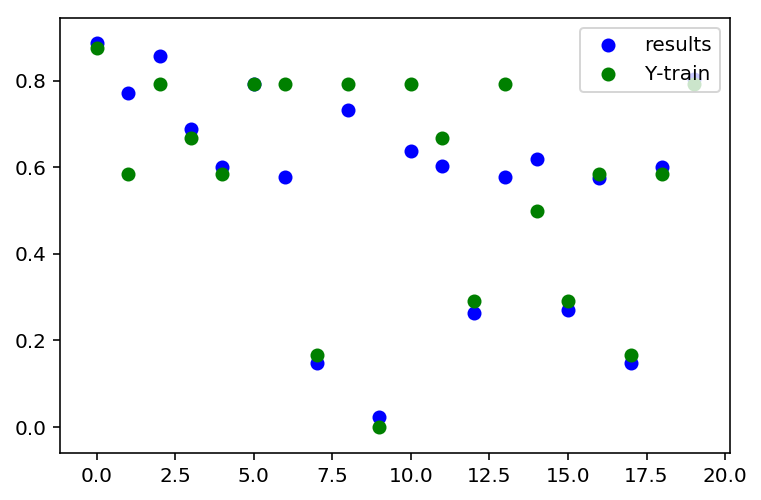

In [12]:
# predict y_train
n=20

results= model.predict(x_train)
plt.scatter(range(n), results[:n], c='b')
plt.scatter(range(n), y_train[:n], c='g')
plt.legend(['results', 'Y-train'], loc='upper right')

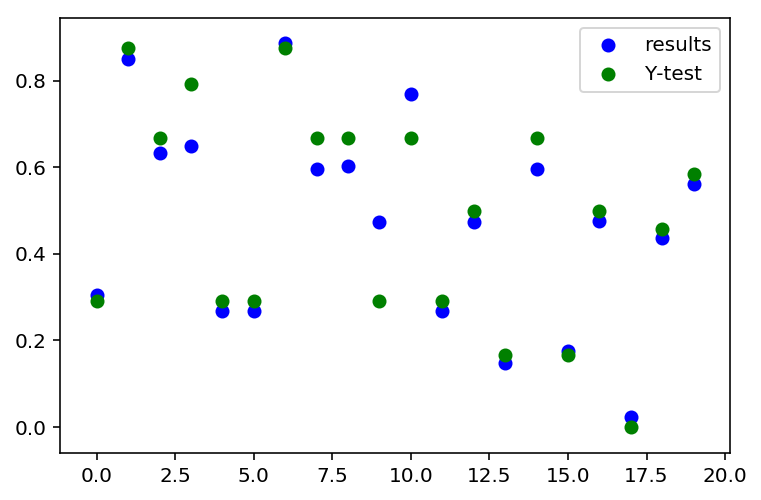

In [13]:
# predict y_test

results= model.predict(x_test)
plt.scatter(range(n), results[:n], c='b')
plt.scatter(range(n), y_test[:n], c='g')
plt.legend(['results', 'Y-test'], loc='upper right')

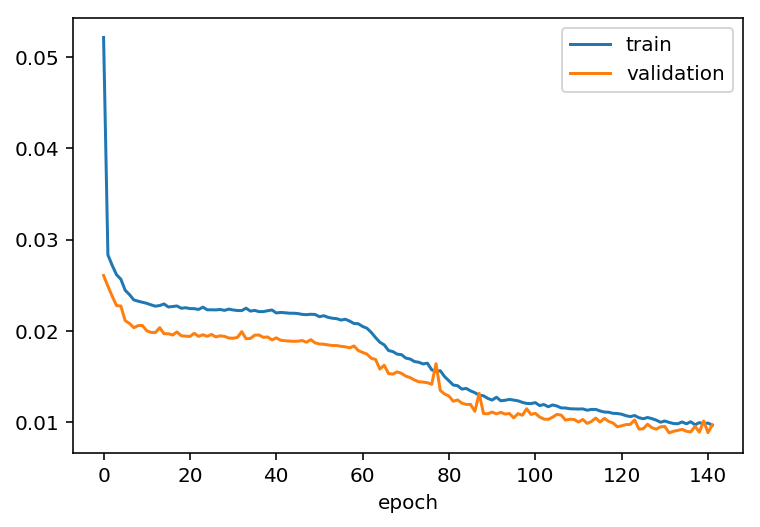

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
# load best weights

# model.load_weights('weights-improvement-57-0.0000455168.hdf5')

# score = model.evaluate(x_test, y_test, batch_size=64)
# print(score)

In [16]:
# create original melody

max_note = max(midi_notes)
min_note = min(midi_notes)
print(f'min_note: {min_note}')
print(f'max_note: {max_note}')

# get sequence to start things off
start_index = random.randrange(0, midi_notes.shape[0] - seq_length)
print(f'start_index: {start_index}')
seed_seq = midi_notes[start_index:start_index + seq_length]

# set start sequence manually
seed_seq = scaler.transform(np.array([60,67,65,64]).reshape(seq_length, 1))
seed_seq = scaler.transform(np.array(midi_notes_org[:seq_length]).reshape(seq_length, 1))

# holds sequence for next prediction
cur_seq = seed_seq.copy()
cur_seq = cur_seq.reshape(1, seq_length, 1)
print(f'cur_seq.shape: {cur_seq.shape}')

# melody starts with our start sequence seed_seq
melody = cur_seq.copy()
print(f'melody.shape: {melody.shape}')

# melody is 500 notes long
melody_length = 500

# cur_seq moves along with the end of the melody to determine the next note
for _ in range(melody_length):
#     print(f'cur_seq: {cur_seq}')
    next_note = model.predict(cur_seq)
#     print(f'next_note: {next_note}')
    melody = np.append(melody, next_note)
#     print(f'melody: {melody}')
    cur_seq = np.append(cur_seq[0][1:], next_note).reshape(1, seq_length, 1)
    

#print(f'melody: {melody}')



min_note: [0.]
max_note: [1.]
start_index: 3524
cur_seq.shape: (1, 4, 1)
melody.shape: (1, 4, 1)


In [17]:
a = np.array([[[0.425],
        [0.25 ],
        [0.375],
        [0.385]]])
a = scaler.transform(np.array([75,75,75,60]).reshape(seq_length, 1))
b = model.predict(a.reshape(1, seq_length, 1))
scaler.inverse_transform(b)

array([[68.709656]], dtype=float32)

In [18]:
# turn melody into a midi file

# print(melody[0])
# print(f'melody.shape: {melody.shape}')

# denormalize
melody_denorm = scaler.inverse_transform(melody.reshape(-1, 1)).flatten()
#print(melody_denorm)
# print(melody_denorm[0])

#melody_denorm = [int(round(n)) for n in melody_denorm ]
#print(melody_denorm)

# write new melody to file
s, fp = to_midi_file(melody_denorm, 'machine_bach.midi')
#s.show('text')
note_letters = [n.pitch.name for n in s.notes]
print(note_letters)


['F', 'G', 'C', 'F', 'F#', 'B-', 'F#', 'A', 'D', 'D', 'G#', 'C#', 'F#', 'E', 'G', 'F#', 'E', 'E', 'E', 'B', 'A', 'C#', 'E-', 'B', 'E', 'F', 'C#', 'G', 'G', 'E', 'G', 'C', 'F', 'C#', 'E', 'G#', 'G#', 'D', 'G', 'E', 'D', 'D', 'C', 'G', 'B-', 'E-', 'E', 'B', 'E-', 'A', 'F', 'F', 'E-', 'E', 'A', 'A', 'C#', 'F#', 'E', 'G#', 'G#', 'D', 'F#', 'F', 'E', 'E-', 'D', 'G#', 'F#', 'C#', 'G#', 'G#', 'G', 'C#', 'E', 'C', 'B-', 'G', 'E', 'E', 'A', 'C', 'F', 'G', 'A', 'F#', 'G#', 'F', 'G#', 'F#', 'G', 'F#', 'G#', 'G#', 'A', 'B-', 'A', 'A', 'G', 'G', 'G', 'G#', 'A', 'B-', 'B-', 'A', 'G#', 'F#', 'F#', 'G', 'G#', 'G#', 'G#', 'A', 'A', 'A', 'A', 'G#', 'G', 'G', 'G', 'A', 'B-', 'B', 'B-', 'G#', 'F#', 'F', 'F#', 'G', 'F#', 'F', 'F#', 'G', 'F#', 'F#', 'F#', 'G', 'G', 'F#', 'G#', 'A', 'B-', 'B-', 'A', 'G', 'F#', 'F#', 'G', 'G#', 'G', 'G', 'A', 'B-', 'B-', 'B-', 'A', 'G', 'F#', 'F#', 'G', 'G#', 'G', 'G#', 'A', 'B-', 'B-', 'B-', 'G#', 'F#', 'F#', 'F#', 'G', 'G', 'G', 'G#', 'B-', 'B-', 'B-', 'A', 'G', 'F#', 'F#',